## Import CTH-UHB Intrapartum CTG Records

This notebook provides an example of importing a FHR and UC record from the open CTH-UHB Intrapartum database on PhysioNet. 

In [67]:
#Import the waveform database library
import wfdb
import numpy as np
import re
np.set_printoptions(threshold=1000)


In [41]:
#Load Physionet databases recognized by the library
dblist = wfdb.getdblist()

In [5]:
#Print List of databases
print (dblist)

[['adfecgdb', 'Abdominal and Direct Fetal ECG Database'], ['aftdb', 'AF Termination Challenge Database'], ['ahadb', 'AHA Database [sample excluded record]'], ['aami-ec13', 'ANSI/AAMI EC13 Test Waveforms'], ['apnea-ecg', 'Apnea-ECG Database'], ['chfdb', 'BIDMC Congestive Heart Failure Database'], ['bpssrat', 'Blood Pressure in Salt-Sensitive Dahl Rats'], ['capslpdb', 'CAP Sleep Database'], ['crisdb', 'CAST RR Interval Sub-Study Database'], ['challenge/2009/test-set-a', 'Challenge 2009 Test Set A'], ['challenge/2009/test-set-b', 'Challenge 2009 Test Set B'], ['challenge/2010/set-a', 'Challenge 2010 Training Set A'], ['challenge/2010/set-b', 'Challenge 2010 Test Set B'], ['challenge/2010/set-c', 'Challenge 2010 Test Set C'], ['challenge/2011/set-a', 'Challenge 2011 Training Set A'], ['challenge/2011/set-b', 'Challenge 2011 Test Set B'], ['challenge/2011/sim', 'Challenge 2011 Pilot Set'], ['challenge/2013/set-a', 'Challenge 2013 Training Set A'], ['challenge/2013/set-b', 'Challenge 2013 Te

In [7]:
#Download the desired database to a local directory
wfdb.dldatabase('ctu-uhb-ctgdb', '/Users/humza/Google Drive/nanodegree/machine-learning-master/projects/capstone/fetal_heart_rate/RawData', records = 'all', annotators = 'all',
           keepsubdirs = True, overwrite = False)


Finished downloading files


In [3]:
#Set path to downloaded data
path = '/Users/humza/Google Drive/nanodegree/machine-learning-master/projects/capstone/fetal_heart_rate/RawData'

In [99]:
#Create a record object by reading one subjects data
record = wfdb.rdsamp(path + '/1017', sampfrom=0, sampto=None, channels=None,
                physical=True, pbdir = None, m2s=True)


In [123]:
#Print and Gather some useful record characteristics
#View sampling frequency
print (record.fs)
#FHR Signal Length
#First column of p_signals is FHR
siglen = len(record.p_signals[:,0])
print(siglen)
#std = np.std(a[:,0])
#print(std)
#a = np.mean(a[np.nonzero(a[:,0])])
#print(a)

headerInfo=record.comments
#Isolate pH
pHstring = headerInfo[2]
pHmatch=re.search('pH\s*(\d+.\d+)',pHstring)
pHmatch2= re.search('pH\s*(\d+)',pHstring)
if pHmatch:
    pH = float(pHmatch.group(1))
if pHmatch2:
    ph = float(pHmatch2.group(1))
print("ph found:",ph)

#Pos stage II- This is position in raw signal sample not an index of an array
posStage2String = headerInfo[40]
posStage2 = re.search('Pos. II.st.\s*(\d+)',posStage2String)
if posStage2:
    posStage2 = int(posStage2.group(1))
print("Position of Stage II is:",posStage2)

#Delivery Type
delTypeString = headerInfo[36]
delType = re.search('Deliv. type\s*(\d+)',delTypeString)
if delType:
    delType = int(delType.group(1))
print("Delivery Type is",delType)

4
21600
ph found: 7.0
Position of Stage II is: 14400
Delivery Type is 1


In [147]:
#Separate Stage I Signal
Stage1Sig = record.p_signals[0:posStage2,0]
Stage1len = len(Stage1Sig)
#print("Length of Stage I is: ",Stage1len," datapoints and ", Stage1len)/4, " sec")))
print("Length of Stage I is: %d datapoints and %.2f seconds" % (Stage1len,Stage1len/4))
#Separate Stage II Signal
Stage2Sig = record.p_signals[posStage2:,0]
Stage2len = len(Stage2Sig)
print("Length of Stage 2 is: %d datapoints and %.2f seconds" % (Stage2len,Stage2len/4))

Length of Stage I is: 14400 datapoints and 3600.00 seconds
Length of Stage 2 is: 7200 datapoints and 1800.00 seconds


In [157]:
#Set Time Length to remove samples from beginning or end of sample
#This is time potentially confounding signal if equipment just started/ended acquisition

#Define Excluded Time-Frame in seconds and number of samples
excTimeFrameSecs = 150
excTimeFrameSamp = 150*4
#Compress by removing zero elements from each when a signal was not able to be acquired
Stage1SigTrim = Stage1Sig[excTimeFrameSamp:]
print("Stage I trimmed length is: %d datapoints and %.2f seconds" % (len(Stage1SigTrim),len(Stage1SigTrim)/4))
Stage2SigTrim = Stage2Sig[0:Stage2len-excTimeFrameSamp]
print("Stage II trimmed length is: %d datapoints and %.2f seconds" % (len(Stage2SigTrim),len(Stage2SigTrim)/4))

#Compress each Signal by removing zero elements
Stage1SigComp = Stage1SigTrim[np.nonzero(Stage1SigTrim)]
Stage2SigComp = Stage2SigTrim[np.nonzero(Stage2SigTrim)]
print("Stage I Compressed length is: %d datapoints and %.2f seconds" % (len(Stage1SigComp),len(Stage1SigComp)/4))
print("Stage II Compressed length is: %d datapoints and %.2f seconds" % (len(Stage2SigComp),len(Stage2SigComp)/4))

print("Mean FHR of entire Stage I Compressed Signal is ",np.mean(Stage1SigComp))
print("Mean FHR of entire Stage II Compressed Signal is ",np.mean(Stage2SigComp))

Stage I trimmed length is: 13800 datapoints and 3450.00 seconds
Stage II trimmed length is: 6600 datapoints and 1650.00 seconds
Stage I Compressed length is: 13381 datapoints and 3345.25 seconds
Stage II Compressed length is: 3908 datapoints and 977.00 seconds
Mean FHR of entire Stage I Compressed Signal is  159.599151782
Mean FHR of entire Stage II Compressed Signal is  116.726010747


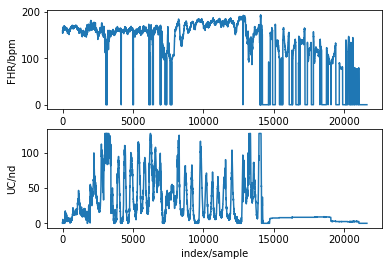

In [119]:
#Use wfdb library to plot records
wfdb.plotrec(record)

In [33]:
#List Signal Length
print (record.siglen)
#List record comments
print (record.comments)

18000
['----- Additional parameters for record 1003', '-- Outcome measures', 'pH           7.2', 'BDecf        3.03', 'pCO2         8.3', 'BE           -5.6', 'Apgar1       7', 'Apgar5       9', '-- !NotReadyYet! Neonatology outcome measures !NotReadyYet!', 'NICU days    0', 'Seizures     0', 'HIE          0', 'Intubation   0', 'Main diag.   0', 'Other diag.  0', '-- Fetus/Neonate descriptors', 'Gest. weeks  40', 'Weight(g)    3770', 'Sex          1', '-- Maternal (risk-)factors', 'Age          31', 'Gravidity    1', 'Parity       0', 'Diabetes     0', 'Hypertension 0', 'Preeclampsia 0', 'Liq. praecox 1', 'Pyrexia      0', 'Meconium     0', '-- Delivery descriptors', 'Presentation 1', 'Induced      1', 'I.stage      215', 'NoProgress   0', 'CK/KP        0', 'II.stage     15', 'Deliv. type  1', '-- Signal information', 'dbID         982315', 'Rec. type    1', 'Pos. II.st.  14400', 'Sig2Birth    0']


In [23]:
#Alternate way of loading a record
#Output signal as a numpy array, and a dictionary of fields describing signal
sig, fields = wfdb.srdsamp(path + '/1003')

In [25]:
#view length of FHR signal
len(sig)

18000

In [26]:
#view dictionary
fields

{'comments': ['----- Additional parameters for record 1003',
  '-- Outcome measures',
  'pH           7.2',
  'BDecf        3.03',
  'pCO2         8.3',
  'BE           -5.6',
  'Apgar1       7',
  'Apgar5       9',
  '-- !NotReadyYet! Neonatology outcome measures !NotReadyYet!',
  'NICU days    0',
  'Seizures     0',
  'HIE          0',
  'Intubation   0',
  'Main diag.   0',
  'Other diag.  0',
  '-- Fetus/Neonate descriptors',
  'Gest. weeks  40',
  'Weight(g)    3770',
  'Sex          1',
  '-- Maternal (risk-)factors',
  'Age          31',
  'Gravidity    1',
  'Parity       0',
  'Diabetes     0',
  'Hypertension 0',
  'Preeclampsia 0',
  'Liq. praecox 1',
  'Pyrexia      0',
  'Meconium     0',
  '-- Delivery descriptors',
  'Presentation 1',
  'Induced      1',
  'I.stage      215',
  'NoProgress   0',
  'CK/KP        0',
  'II.stage     15',
  'Deliv. type  1',
  '-- Signal information',
  'dbID         982315',
  'Rec. type    1',
  'Pos. II.st.  14400',
  'Sig2Birth    0'],

In [32]:
#view the sampling frequency field
fields['fs']

4